In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mitgcm
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12) # set default figure size to 12x12 inches

In [2]:
path_to_output = 'data/1_deg_spherical_sector/'

m = mitgcm.MITgcm_Simulation(path_to_output,'grid.1degree.nc', ntiles_x=3, ntiles_y=6,grid_type='polar')

state_files = 'mnc*/state*'

In [3]:
mitgcm.functions.show_variables('mnc_test*/state.*')

[u'T', u'iter', u'Xp1', u'Y', u'Z', u'U', u'X', u'Yp1', u'V', u'Temp', u'S', u'Eta', u'Zl', u'W']


In [4]:
time_level = -1
m.free_surface = mitgcm.Tracerpoint_field(m,state_files,'Eta',time_level,field_name='ETAN')
m.meridional_velocity = mitgcm.Vpoint_field(m,state_files,'V',time_level,field_name='VVEL')
m.zonal_velocity = mitgcm.Upoint_field(m,state_files,'U',time_level,field_name='UVEL')
m.temperature= mitgcm.Tracerpoint_field(m,state_files,'Temp',time_level,field_name='THETA')
m.vertical_velocity = mitgcm.Wpoint_field(m,state_files,'W',time_level,field_name='WVEL')

m.density = mitgcm.Density(m)
m.pressure = mitgcm.Pressure(m)
m.bernoulli = mitgcm.Bernoulli(m)

<matplotlib.colorbar.Colorbar instance at 0x10c334638>

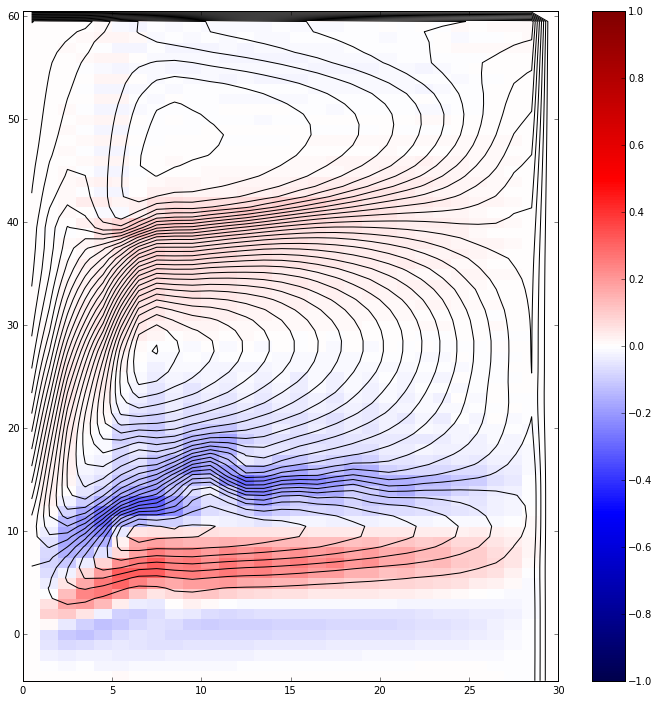

In [5]:
level = 2
#im = plt.pcolormesh(m.grid['X'][:],m.grid['Y'][:], m.temperature['THETA'][level,:,:],cmap='Blues')
im = plt.pcolormesh(m.grid['Xp1'][:],m.grid['Y'][:],m.zonal_velocity['UVEL'][level,:,:],
                    cmap='seismic', vmin= -1, vmax = 1)
#im = plt.pcolormesh(m.grid['X'][:],m.grid['Yp1'][:],m.meridional_velocity['VVEL'][level,:,:],
#                    cmap='seismic', vmin= -1, vmax = 1)
#im = plt.pcolormesh(m.grid['X'][:],m.grid['Y'][:],m.vertical_velocity['WVEL'][level,:,:])
#im = plt.pcolormesh(m.grid['X'][:],m.grid['Y'][:],m.bernoulli['BP'][level,:,:],cmap='seismic')
#im = plt.pcolormesh(m.grid['X'][:],m.grid['Y'][:],m.free_surface['ETAN'][:,:],cmap='seismic',vmin=-1,vmax=1)
plt.contour(m.grid['X'][:],m.grid['Y'][:],m.bernoulli['BP'][level,:,:],30,colors='k')
#im = plt.pcolormesh(m.free_surface['ETAN'][0,:,3:])
plt.colorbar(im)

# Interpolate onto a quarter degree grid

In [6]:
dx = 0.25

xp1_highres = np.arange(m.grid['Xp1'][0], m.grid['Xp1'][-1]+dx, dx)
x_highres = (xp1_highres[1:] + xp1_highres[:-1])/2

yp1_highres = np.arange(m.grid['Yp1'][0], m.grid['Yp1'][-1]+dx, dx)
y_highres = (yp1_highres[1:] + yp1_highres[:-1])/2


temp = np.ma.array(m.temperature['THETA'][:],mask=1-m.grid['HFacC'][:])
NANmask = temp.filled(np.NAN)
temp_interpolated = mitgcm.functions.interp_field(NANmask,m.grid['X'][:],m.grid['Y'][:],
                        x_highres,y_highres,interp_order=3,fill_nans='yes')

temp = np.ma.array(m.zonal_velocity['UVEL'][:],mask=1-m.grid['HFacW'][:])
NANmask = temp.filled(np.NAN)
u_interpolated = mitgcm.functions.interp_field(NANmask,m.grid['Xp1'][:],m.grid['Y'][:],
                                                  xp1_highres,y_highres,interp_order=3,fill_nans='yes')

temp = np.ma.array(m.meridional_velocity['VVEL'][:],mask=1-m.grid['HFacS'][:])
NANmask = temp.filled(np.NAN)
v_interpolated = mitgcm.functions.interp_field(NANmask,m.grid['X'][:],m.grid['Yp1'][:],
                                                  x_highres,yp1_highres,interp_order=3,fill_nans='yes')

temp = np.ma.array(m.free_surface['ETAN'][:],mask=1-m.grid['HFacC'][0,:,:])
NANmask = temp.filled(np.NAN)
eta_interpolated = mitgcm.functions.interp_field(NANmask.reshape((1,NANmask.shape[0],NANmask.shape[1])),
                                                 m.grid['X'][:],m.grid['Y'][:],
                                                  x_highres,y_highres,interp_order=3,fill_nans='yes')


### Export interpolated fields to start the model at a new resolution

The fields need to be exported as binary files that the model can read when it starts. They also need to be exported  without the extra entries in u and v.

In [9]:
try:
    os.mkdir('interpolated_fields')
except:
    pass

mitgcm.functions.export_binary('interpolated_fields/temp.interpolated.bin',temp_interpolated)
mitgcm.functions.export_binary('interpolated_fields/u.interpolated.bin',u_interpolated[:,:,:-1])
mitgcm.functions.export_binary('interpolated_fields/v.interpolated.bin',v_interpolated[:,:-1,:])
mitgcm.functions.export_binary('interpolated_fields/eta.interpolated.bin',eta_interpolated)


<matplotlib.contour.QuadContourSet instance at 0x10c906ab8>

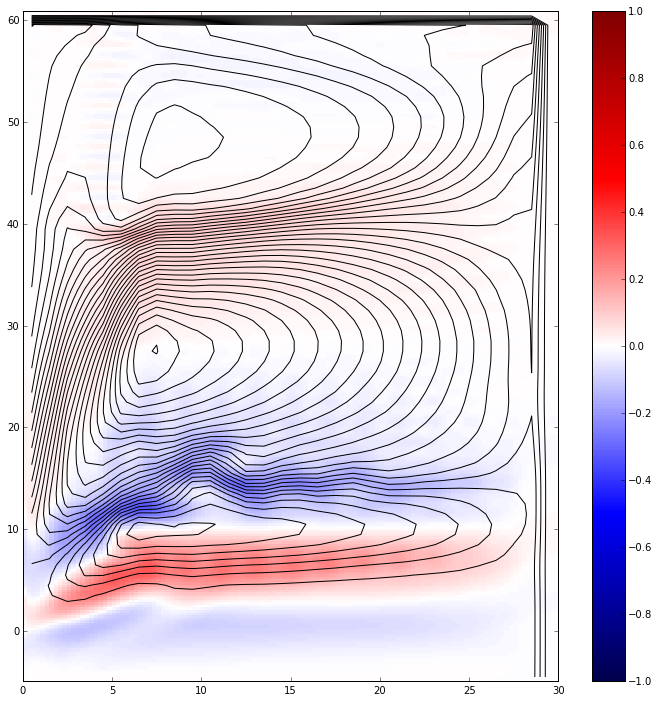

In [8]:
im = plt.pcolormesh(xp1_highres,y_highres,u_interpolated[level,:,:],
                    cmap='seismic', vmin= -1, vmax = 1)
plt.colorbar(im)
plt.contour(m.grid['X'][:],m.grid['Y'][:],m.bernoulli['BP'][level,:,:],30,colors='k')